Copyright &copy; 2015 Ondrej Martinsky, All rights reserved

[www.quantandfinancial.com](http://www.quantandfinancial.com)
# Heath Jarrow Morton Model (HJM)

### Initialize libraries and define functions

In [1]:
#from numpy import testing
from mpl_toolkits.mplot3d import Axes3D
from copy import copy
from progressbar import *
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (13, 4.5)
numpy.random.seed(0)

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Load Historical Data

Timeline shape:  (1264,)
Tenors shape  :  (51,)
Rates shape   :  (1264, 51)


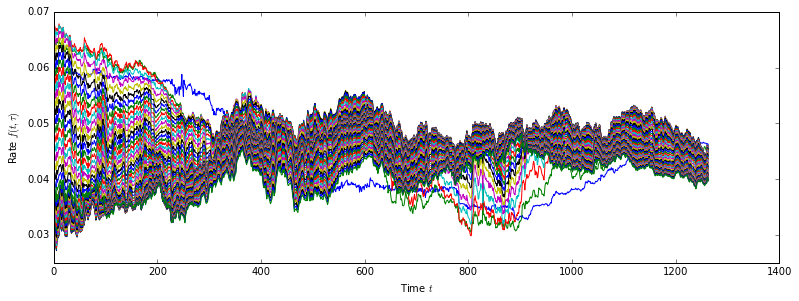

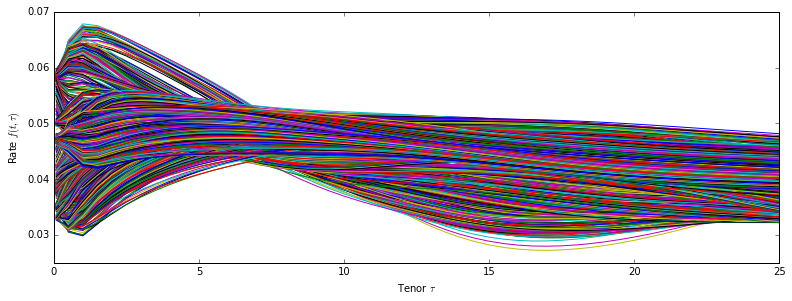

In [2]:
def load(file):
    m = []
    check_row_len = None
    for i, line in enumerate(open(file).read().splitlines()):
        cells = [(float(x) if x!=r'Tenor' else -999) for x in line.split(',')]
        if check_row_len is None:
            check_row_len = len(cells)
        assert len(cells)==check_row_len, "%i vs %i" % (len(cells), check_row_len)
        m.append(cells)
    m = matrix(m)
    tenors = array(m[0,1:].flatten())[0]     # Flatten values and put them to one-dimensional vector
    timeline = array(m[1:,0].flatten())[0]   # Flatten values and put them to one-dimensional vector
    rates = m[1:,1:]
    rates *= .01 # Rates are stored as percentages 0..100, convert to 0..1
    assert rates.shape[1]==tenors.shape[0]
    assert rates.shape[0]==timeline.shape[0]
    return timeline, tenors, rates
hist_timeline, tenors, hist_rates = load('hjm_data.csv')
print('Timeline shape: ',str(hist_timeline.shape))
print('Tenors shape  : ',str(tenors.shape))
print('Rates shape   : ',str(hist_rates.shape))
plot(hist_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
show()
plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');

### Calculate Differences
differentiate rates matrix, so dimensions will become $[n , m] \rightarrow [n-1 , m]$

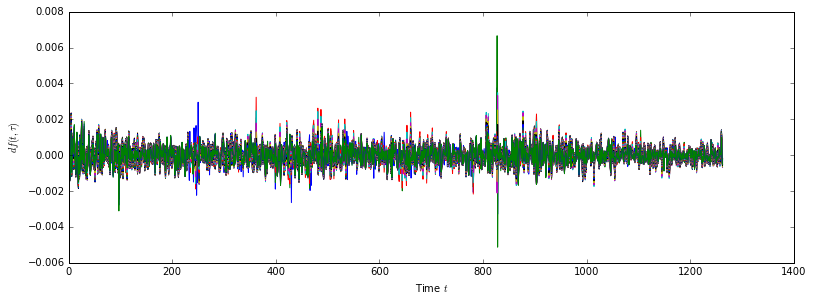

In [3]:
diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
plot(diff_rates), xlabel(r'Time $t$'), ylabel(r'$df(t,\tau)$');

### PCA

#### Calculate covariance matrix $\Sigma$

In [4]:
sigma = cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (51, 51)


##### Source data are daily rates, therefore annualize covariance

In [5]:
sigma *= 252

#### Calculate eigenvalues and eigenvectors

In [6]:
eigval, eigvec = linalg.eig(sigma)
eigvec=matrix(eigvec)
assert type(eigval) == ndarray
assert type(eigvec) == matrix
print(eigval)

[  2.02884026e-03   4.62889282e-04   1.63677691e-04   8.47948767e-05
   5.10134525e-05   3.26491422e-05   1.53862297e-05   3.90765854e-06
   1.45385608e-06   3.99451240e-07   7.74123143e-08   2.25094249e-08
   6.81015623e-09   2.04941470e-09   8.30654931e-10   3.18422195e-10
   1.69855214e-10   1.20686738e-10   8.18818617e-11   4.65678092e-11
   2.41691462e-11   1.26818402e-11   7.83625335e-12   4.07032932e-12
   2.61696278e-12   1.78998719e-12   1.07235657e-12   6.26516041e-13
   3.36666653e-13   2.89485011e-13   2.09896579e-13   2.02354381e-13
   1.20791341e-13   9.80003466e-14   7.30529080e-14   5.84907881e-14
   5.01856498e-14   4.50403300e-14   4.25120847e-14   3.00510006e-14
   1.99690948e-14   1.44920719e-14   8.67035701e-15   6.67577109e-15
   5.37147258e-15   4.23420881e-15   2.52352125e-15   1.26756005e-15
   4.34535961e-17   1.87399622e-16   2.51659872e-16]


#### Determine principal components
Select eigen vectors with highest eigenvalues
<font color=red>Link between tenors and eigenvectors is not guaranteed</font>

Principal eigenvalues
[ 0.00202884  0.00046289  0.00016368]

Principal eigenvectors
[[ 0.00351033 -0.00972625 -0.00111508]
 [ 0.05665586 -0.16326718  0.27313784]
 [ 0.10114279 -0.2389149   0.40222423]
 [ 0.11563974 -0.24345609  0.35581018]
 [ 0.12154093 -0.23509872  0.27474251]
 [ 0.12568249 -0.22656368  0.19585028]
 [ 0.12948968 -0.21903235  0.12500321]
 [ 0.13320457 -0.21206961  0.0623539 ]
 [ 0.13681963 -0.2051638   0.00709335]
 [ 0.14026214 -0.19791715 -0.04135353]
 [ 0.14344533 -0.19001071 -0.08325192]
 [ 0.1462834  -0.18118042 -0.11865757]
 [ 0.14870205 -0.17120748 -0.14754572]
 [ 0.15064229 -0.15990426 -0.16990336]
 [ 0.15207044 -0.14712506 -0.18581986]
 [ 0.15298157 -0.13278428 -0.19552188]
 [ 0.15340022 -0.11686787 -0.19936452]
 [ 0.15337685 -0.09943599 -0.19785291]
 [ 0.15297871 -0.08062996 -0.19159875]
 [ 0.15228467 -0.06067689 -0.18129946]
 [ 0.15138052 -0.03988003 -0.16770213]
 [ 0.15035008 -0.01860959 -0.15155688]
 [ 0.1492673   0.00271527 -0.13358986]
 [ 0.14819153  0.02

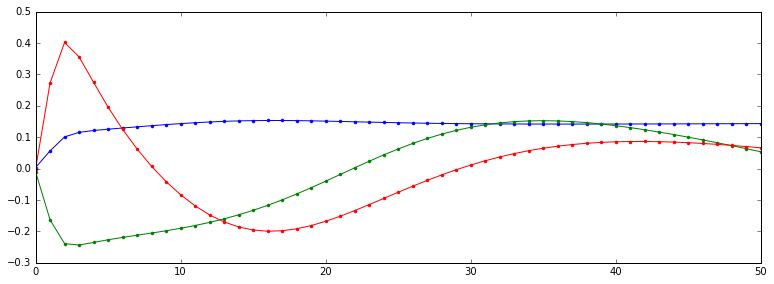

In [7]:
factors=3
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec])
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)
plot(princ_comp, marker='.');

### Calculate discretized volatility function from principal components

vols shape: (51, 3)


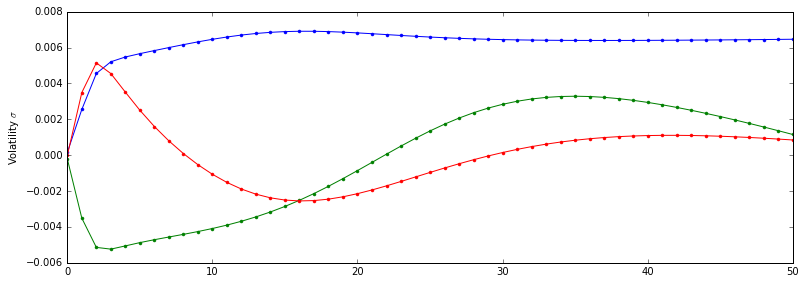

In [8]:
sqrt_eigval = matrix(princ_eigval ** .5)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
print('vols shape: ' + str(vols.shape))
plot(vols, marker='.'), ylabel(r'Volatility $\sigma$');

### Volatility Fitting
<b>Fit Volatility Functions $\bar{v}(t,\tau)$ from discretized versions</b><br>
<b>Fitting is done using <u>cubic spline</u></b><br>

Set degree of interpolator for i-th principal component.

In [9]:
deg = lambda i: 0 if i==0 else 3

#### Create cubic interpolator

In [10]:
def column_as_array(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C))

fitted_vols = []        
        
for ipc, col in enumerate(range(vols.shape[1])):
    volatilities = column_as_array(vols, col)
    params = polyfit(tenors, volatilities, deg(ipc))
    fitted_vols.append(PolynomialInterpolator(params))
    print("Interpolator parameters = ", str(params))

Interpolator parameters =  [ 0.0062116]
Interpolator parameters =  [ -3.58119290e-06   1.17687151e-04  -5.62974696e-04  -3.56815899e-03]
Interpolator parameters =  [ -3.17924240e-06   1.43686867e-04  -1.77966158e-03   4.82391142e-03]


#### Use Cubic interpolator

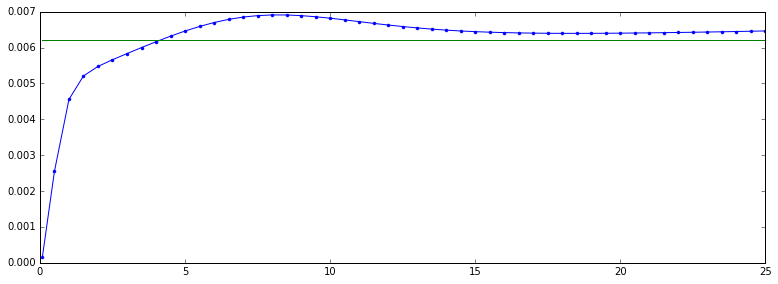

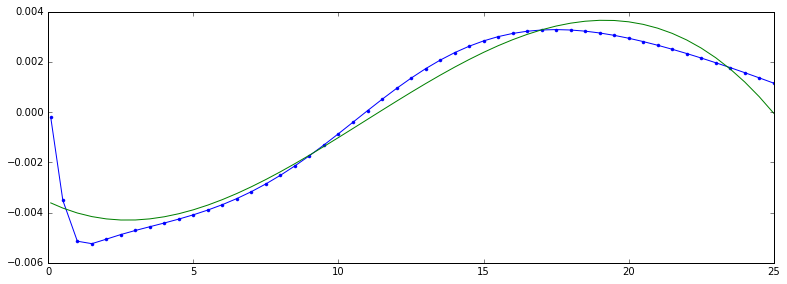

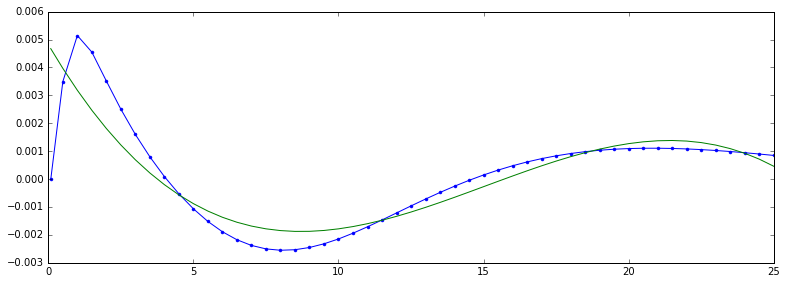

In [11]:
for col in range(vols.shape[1]):
    volatility_vector = column_as_array(vols, col)
    plot(tenors, volatility_vector, marker='.')
    fitted_volatility_vector = fitted_vols[col]
    plot(tenors, [fitted_volatility_vector.calc(x) for x in tenors])
    show()

### Monte Carlo

#### Define function for numeric integration
We will use trapezoidal rule:
$$\int_0^t v(\tau)d\tau \approx \sum_{0}^{n} \frac{1}{2}(v_{i+1}-v_i)\times d\tau$$

In [12]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, n)):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

#### Discretize fitted volatilities for the purpose of MC Calculation

Volatilities


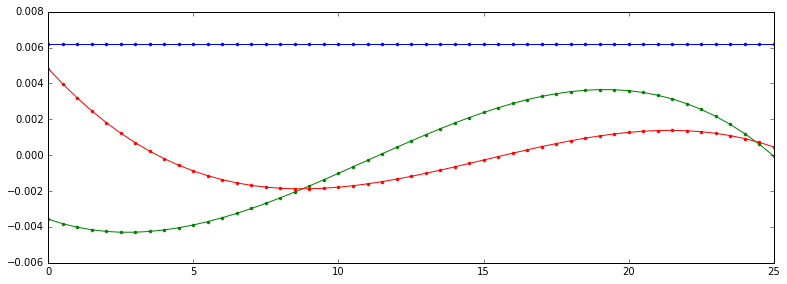

In [13]:
mc_tenors = linspace(0,25,51)
# Discretize fitted volfuncs for the purpose of monte carlo simulation
print("Volatilities")
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
plot(mc_tenors, mc_vols, marker='.');

#### Drift calculation
Drift $m(t,\tau)$ is calculated using numerical integration over fitted volatility functions (No Mursiela parameterisation for now)<br><br>
$$ m(t,\tau) = \sum_{i=1}^n v_i(t,\tau) \int_0^\tau v_i(t,s)ds $$

In [14]:
def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator)
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

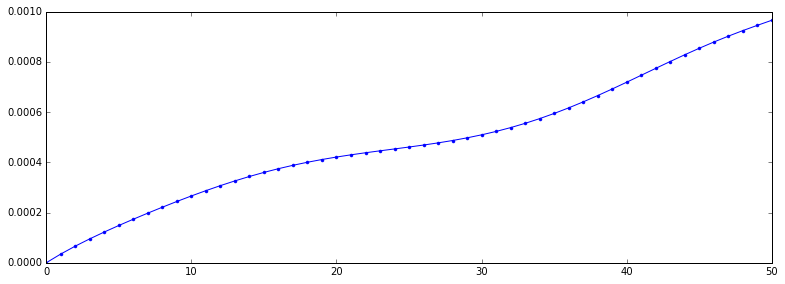

In [15]:
mc_drift = array([m(tau, fitted_vols) for tau in mc_tenors])
plot(mc_drift, marker='.');

#### Perform MC Simulation (one path)

Few formulas
$$f(t,T)=F(t;T,T+\delta T)$$
$$df(t,T) = m(t,T)dt + \sum^N_{i=1}v_i(t,T)dX_i$$
$$m(t,T)=\sum^N_{i=1}v_i(t,T)\int_t^Tv_i(t,s)ds$$
Mursiela parameterisation
$$\bar{f}(t,\tau)=f(t,t+\tau)$$

The multi-factor HJM framework is implemented with this SDE:
$$d\bar{f}(t,\tau)=(\sum_{i=1}^k \bar{v}_i(t,\tau)\int_0^\tau {v}_i(t,s)ds+\frac{\delta\bar{f}(t,\tau)}{\delta\tau})dt + \sigma_{i=1}^k \bar{v}_i(t,\tau)dX_i$$

We simulate by $f(t+dt)=f(t) + d\bar{f}$   where Musiela HJM SDE is $d\bar{f} =  m(t)dt+\sum(v_i*\phi*\sqrt{dt})+\frac{dF}{d\tau}dt$

#### today's instantenous forward rates $f(t_0, T)$

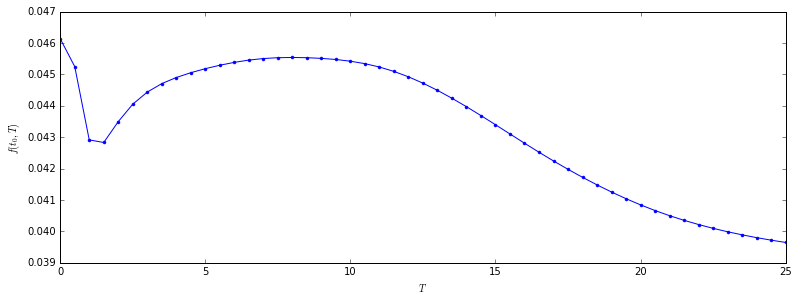

In [16]:
curve_spot = array(hist_rates[-1,:].flatten())[0]
plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$");

In [17]:
def simulation(f, tenors, drift, vols, timeline):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copy(f)
        random_numbers = [normal() for i in range(len_vols)]
        for iT in range(len_tenors):
            val = fprev[iT] + drift[iT] * dt
            #
            sum = 0
            for iVol, vol in enumerate(vols):
                sum += vol[iT] * random_numbers[iVol]
            val += sum * sqrt_dt
            #
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

One simulation path 
0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%

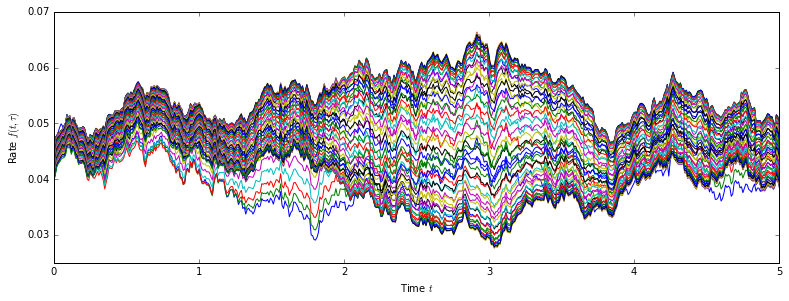

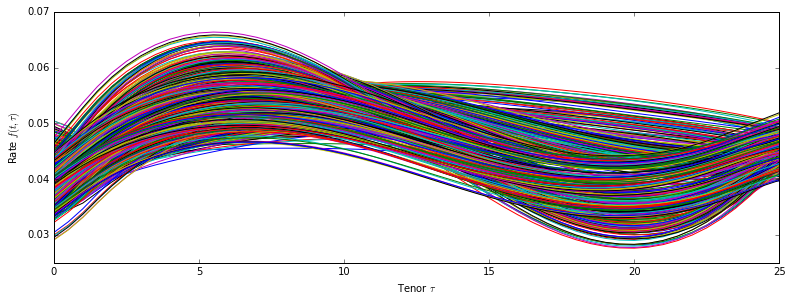

In [18]:
proj_rates = []
proj_timeline = linspace(0,5,500)
progressbar = ProgressBar("One simulation path", len(proj_timeline))
for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    progressbar.update(i)
    proj_rates.append(f)
proj_rates = matrix(proj_rates)
plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
show()
plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');

### Pricing of trade using Monte Carlo

#### Define integrator for instatenous rates

Integrating $f(t)$ over $n$ discrete samples:
$$\int_{t_1}^{t_n} f(t)dt \approx \frac{(t_n-t_1)}{n}\sum_{i=1}^n f(t_i)$$
<b>Simple</b> LIBOR forward rate (e.g. 3M libor)
$$F(t_0;t,T) = \int_{t}^{T} f(t_0, s)ds$$

In [19]:
class Integrator:
    def __init__(self, x0, x1):
        assert x0 < x1
        self.sum, self.n, self.x0, self.x1= 0, 0, x0, x1
    def add(self, value):
        self.sum += value
        self.n += 1
    def get_integral(self):
        return (self.x1 - self.x0) * self.sum / self.n

#### Price caplet

Caplet with strike $K=3\%$, expiring in $t_s=1.0$, maturing in $t_e=2.0$, notional $N=1,000,000$

Performing simulation 
0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%

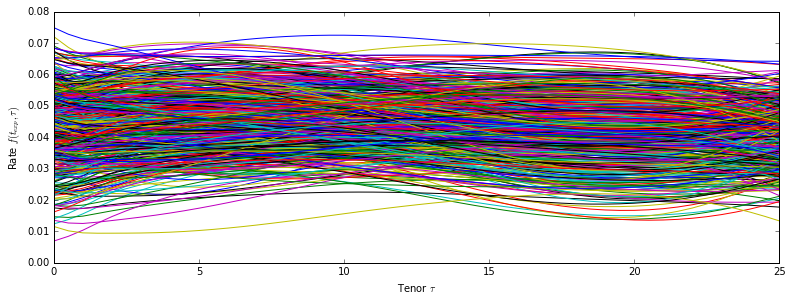

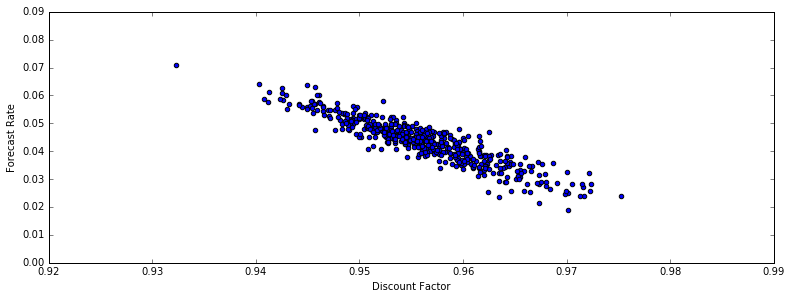

Final value: 13078.429431


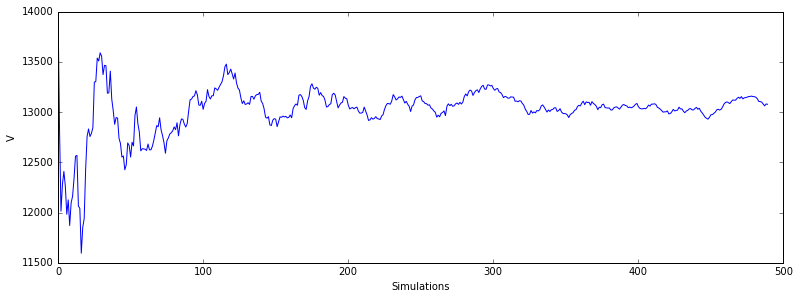

In [20]:
t_exp = 1.
t_mat = 2.
K = .03
notional = 1e6
n_simulations = 500
n_timesteps = 50
proj_timeline = linspace(0,t_mat, n_timesteps)
progressbar = ProgressBar('Performing simulation', n_simulations)
simulated_forecast_rates = []
simulated_df = []
simulated_payoffs = []
payoff_convergence_process = []
for i in range(0, n_simulations):
    progressbar.update(i)
    rate_forecast = None                    # Forecast rate between t_exp and t_mat for this path
    rate_discount = Integrator(0, t_exp)      # cont.compounded discount rate for this path
    for t, curve_fwd in simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline):
        f_t_0 = interp(0., mc_tenors, curve_fwd)  # rate $f_t^0$
        rate_discount.add(f_t_0)
        if t>=t_exp and rate_forecast is None:  # t is expiration time
            Tau = t_mat-t_exp
            rate_forecast = Integrator(0, Tau) # integrate all inst.fwd.rates from 0 till 1Y tenor to get 1Y spot rate
            for s in linspace(0, Tau, 15): # $\int_0^T f(t,s)ds$
                f_texp_s = interp(s, mc_tenors, curve_fwd)
                rate_forecast.add(f_texp_s) 
            rate_forecast = rate_forecast.get_integral()
    plot(mc_tenors, curve_fwd), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t_{exp},\tau)$');   # Plot forward curve at expiration
    df = exp(-rate_discount.get_integral())     # Discount factor
    simulated_forecast_rates.append(rate_forecast)
    simulated_df.append(df)
    payoff = max(0, rate_forecast - K) * (t_mat-t_exp) * notional * df
    simulated_payoffs.append(payoff)
    payoff_convergence_process.append(average(simulated_payoffs))
show()
#
scatter(simulated_df, simulated_forecast_rates), xlabel('Discount Factor'), ylabel('Forecast Rate')
show()
#
plot(payoff_convergence_process[10:]), xlabel("Simulations"), ylabel("V");
print("Final value: %f" % payoff_convergence_process[-1])